# Pixel Art Upscale

Graphics in past video games were represented at the pixel level. This form of digital art is known as pixel art. This artwork was usually arranged by hand at the pixel level because of the hardware constraints at the time–this is opposed to the standard now of doscaling the high-resolution images.

We will be attempting to upscaling some iconic pixel art such as mario characters and other classic video game characters. We will start with some older implementation methods that have limitations on the magnification factor and we will finish with the most refined implementation developed by **Johannes Kopf and Dani Lischinski**.

The implementation by Kopf and Lischinski is most definitely the most advanced algorithm of the 3 that we are attempting to implement. Part of the difficulty is that we do not know what heuristics they are using so we will have to experiment with these numbers on are own. Additionally, have a low number of linear transformations needed, opposed to Kopf and Lischinski's which will require us to reshape the pixels, produce a Voroni graph, initialize spline curves, optimize the spline curves for control points, and render the image based off pixel-color averages.


# Install packages


In [10]:
from bilinear import *
from epx import *
from curves import *
from collapse import *
from nearestNeighbors import *
from render import *
from similarityGraph import *
from utils import * 
from voronoi import *

import cv2
import numpy as np
import networkx as nx

%matplotlib inline

# Option 1: General Upscaling Techniques

Apply linear filtering to upsample images


The “classical” approach to image upsampling is to apply linear filters derived either from analytical interpolation or from signal processing theory. Examples include filters such as Nearest-Neighbor, Bicubic, and Lancosz [Wolberg 1990]. These filters make no assumptions about the underlying data, other than that it is essentially band-limited. As a consequence, images upsampled in this manner typically suffer from blurring of sharp edges and ringing artifacts. Here we implement two general upscaling techniques including Nearest-Nieghbor and Bilinear.

Further Detailing on Algorithms:
- https://en.wikipedia.org/wiki/Nearest-neighbor_interpolation
- https://en.wikipedia.org/wiki/Bilinear_interpolation


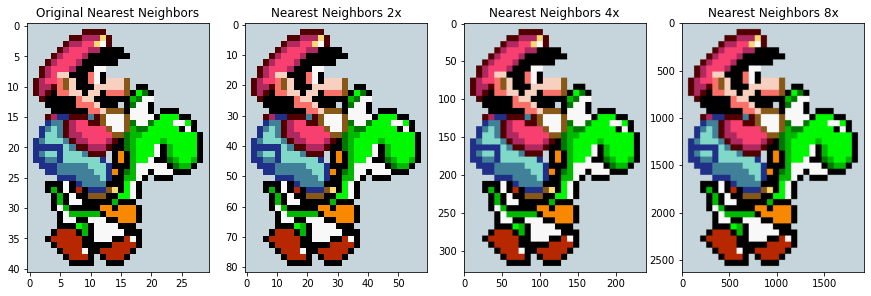

In [5]:
path = 'inputs/mario_yoshi.png'
image = cv2.imread(path)

image_2x = nearestNeighborsInterpolation(image, 2)
image_4x = nearestNeighborsInterpolation(image_2x, 4)
image_8x = nearestNeighborsInterpolation(image_4x, 8)
display_upscales("Nearest Neighbors", [image, image_2x, image_4x, image_8x])

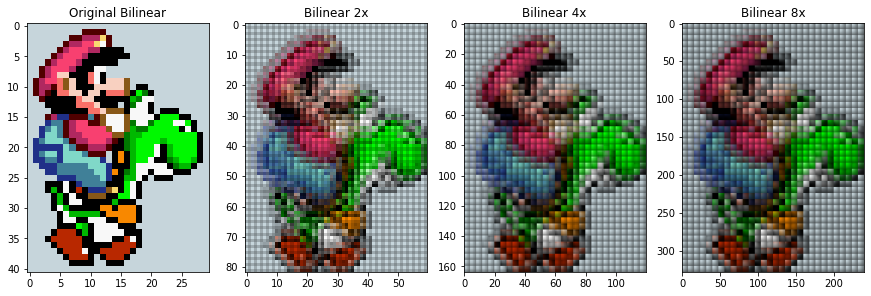

In [6]:
path = 'inputs/mario_yoshi.png'
image = cv2.imread(path)

image_2x = bilinearInterpolation(image, 2)
image_4x = bilinearInterpolation(image, 4)
image_8x = bilinearInterpolation(image, 8)
display_upscales("Bilinear", [image, image_2x, image_4x, image_8x])

# Option 2: Pixel Art Upscaling Techniques

Emulation technique that is based on a fixed integer factor EPX.

EPX is a naive solution that increases the resolution of an image by a factor of two using a straightforward approach. At the beginning, every pixel in the original image is replaced by a 2x2 block of pixels with the same color. However, if the adjacent pixels to the left and above the current pixel in the original image have the same color, that color is used to replace the top-left pixel in the 2x2 block. The same logic applies to the other three corners of the block. There are a few more additional constraints that deal with not doing replacement if 3 of the surrounding pixels are equivalent.

Further Detailing on Algorithm:

- https://en.wikipedia.org/wiki/Pixel-art_scaling_algorithms#:~:text=Eric's%20Pixel%20Expansion%20(EPX)%20is,or%20less%20double%20that%20resolution.


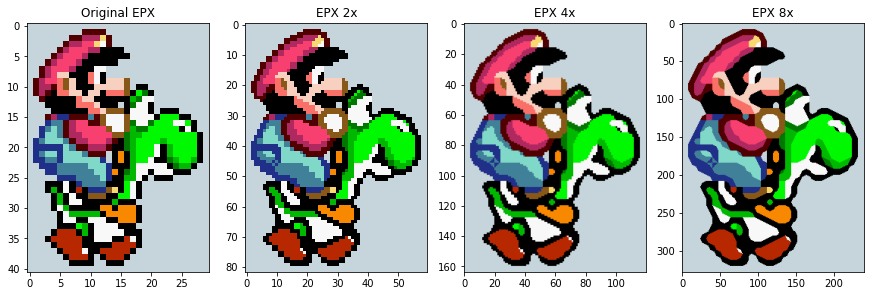

In [7]:
path = 'inputs/mario_yoshi.png'
image = cv2.imread(path)

image_2x = epx_upsample(image)
image_4x = epx_upsample(image_2x)
image_8x = epx_upsample(image_4x)
display_upscales("EPX", [image, image_2x, image_4x, image_8x])

# Option 3 Belser Gluszak Kuang and Moon Implementation (Adapted from Kopf and Lischinski Algorithm)

Milestone steps to upscale 8-bit pixel art vectors:

- Milestone 1: Reshaping the pixels using the heuristics to make sure that they are grouped with their neighbors by creating a similarity graph
- Milestone 2: Create a simplified Voronoi graph from a similarity graph
- Milestone 3: Initializing spline curves from the Voronoi graph
- Milestone 4: Optimizing spline curves by improving locations of control point
- Milestone 5: Rendering


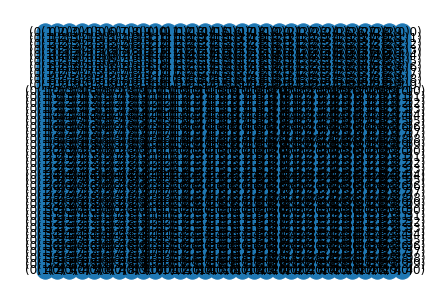

In [17]:
path = './inputs/mario_yoshi.png'
image = cv2.imread(path)

graph = create_similarity_graph(image)
graph = remove_diagonals(graph, image)
pos = {(x,y):(x, -y) for x, y in graph.nodes()}
nx.draw(graph, pos=pos, with_labels=True)


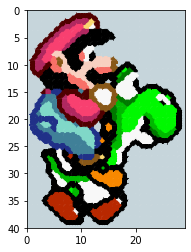

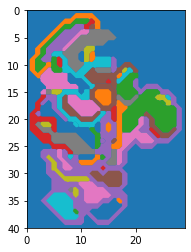

In [9]:
height, width, _ = image.shape
graph = add_midpoints(graph)
points = np.array([node for node in graph.nodes()])
vor = voronoi(points, np.array([-1, width, -1, height]))

point_to_region = get_region_point_indices(vor)

graph_voronoi(width, height, vor, graph, point_to_region)
segments = get_collapsed_segments(graph, vor, point_to_region, width, height)


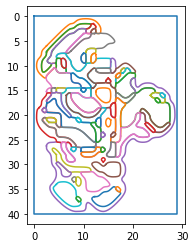

In [11]:
curves = smooth_image(segments, width, height)

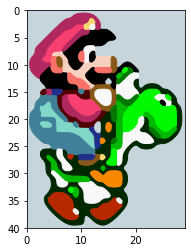

In [31]:
render_image(curves, width, height, graph)